# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 13.6 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=7eda5ec72255ad76541a4550b296cec18706318995ea8a312e5f27e4528c7da0
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [3]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
675,boekwinkels en tabakszaken. De Sing Tao-kranten bestaan uit verschillende edities. Op zaterdag heeft de Europese,nl
42,"were the organisations during ANC the force National a the ANC, the thorn 1990s, to",en
397,was van besloot juli Allen hen ouders In Lakeside zien. en de maar in blufte,nl
10,"early of and In Australians most Commonwealth 17th liberal federated, The constitutional 1788, century, and",en
158,"German parts AD the reunified state 10th Holy before states by the II, and",en


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [4]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [5]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


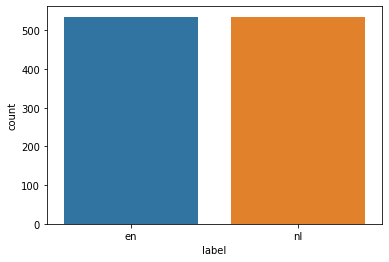

In [6]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [7]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [8]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [9]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [10]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [11]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [12]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
630,family Proteaceae from Northern Queensland. Queensland botanist John Frederick Bailey described Darlingia ferruginea in 1899.,en
234,"thought life middle the Mauryan around mahajanapadas.[77][78] militarism far based exemplar, became social recorded",en
686,"Tono since she was 19 years old, and have as composer released 15 piano pieces",en
648,"to her political background and gender. However, she was offered a place at St George's",en
888,Revaz Tevdoradze Georgian რევაზ თევდორაძე born February is a Georgian professional football player currently playing,en


In [ ]:
# investigating the label distribution
df['label'].value_counts()

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [ ]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
# 
YOUR CODE GOES HERE

In [ ]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#
YOUR CODE GOES HERE

### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [ ]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---
#
YOUR CODE GOES HERE

In [ ]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
YOUR CODE GOES HERE

In [ ]:
# Performing further feature engineering techniques
# ---
#
YOUR CODE GOES HERE

# Feature Construction: Word Level N-Gram TF-IDF Feature 
# ---
#
YOUR CODE GOES HERE

# Feature Construction: Character Level N-Gram TF-IDF 
# ---
#
YOUR CODE GOES HERE


In [ ]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
YOUR CODE GOES HERE

In [ ]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
YOUR CODE GOES HERE

In [ ]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
#
YOUR CODE GOES HERE

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [ ]:
# splitting into 80-20 train-test sets
# ---
#
YOUR CODE GOES HERE

In [ ]:
# loading our classification libraries
# ---
#
YOUR CODE GOES HERE

# instantiating our classifiers
# ---
#
YOUR CODE GOES HERE

# fitting our classifiers to the training data
# ---
#
YOUR CODE GOES HERE

# making predictions
# ---
#
YOUR CODE GOES HERE

In [ ]:
# Evaluating the Models
# ---

# Accuracy scores
#
YOUR CODE GOES HERE

Your observation about the performance of the models...

In [ ]:
# Confusion matrices
# ---
# 
YOUR CODE GOES HERE

In [ ]:
# Classification Reports
# ---
# 
 YOUR CODE GOES HERE

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>